In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sys
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import log_sum_exp
from util_svae import *
import numpy as np
from spiral import *
import torch.nn as nn
from torch.nn import Parameter
import sys
from torchvision import datasets, transforms
import pickle
import time
%matplotlib inline
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+80380f6 cuda: True


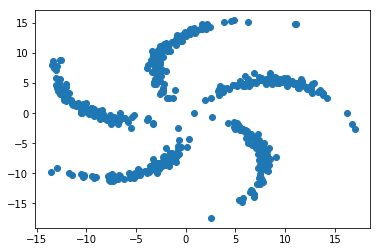

In [2]:
num_clusters = 5          # number of clusters in pinwheel data
samples_per_cluster = 100  # number of samples per cluster in pinwheel
spiral_data, labels = make_pinwheel_data(0.3, 0.05, num_clusters, samples_per_cluster, 0.25)
plt.scatter(spiral_data[:,0], spiral_data[:, 1])

In [3]:
K = 5               # number of components in mixture model
D = 2 # latent dimension
B = 2
N = num_clusters * samples_per_cluster
Y = torch.FloatTensor(spiral_data)

#############
# model parameters
NUM_HIDDEN = 128
NUM_LATENTS = 2
NUM_OBS = 2
# training parameters
NUM_SAMPLES = 1
BATCH_SIZE = 500
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()

RESTORE = False


In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=B,
                       num_hidden=NUM_HIDDEN,
                       num_latents=D):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.latent_log_var = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    @expand_inputs
    def forward(self, obs, batch_size, num_samples=None):
        q = probtorch.Trace()
        hidden = self.enc_hidden(obs)
        nn_mean = self.latent_mean(hidden).squeeze(0)
        nn_std = torch.exp(self.latent_log_var(hidden))
        nn_full_std = torch.zeros((batch_size, D, D)).cuda()
        nn_full_std[:, torch.arange(D).long(), torch.arange(D).long()] = nn_std.squeeze(0)
#         std_filter = torch.eye(D).repeat(batch_size, 1, 1).unsqueeze(0).cuda()
#         nn_full_std = torch.mul(std_filter, nn_std.repeat(D, 1, 1, 1).permute(1, 2, 0, -1)).squeeze(0)
        nn_eta2 = torch.zeros((batch_size, D, D)).cuda()
        for n in range(batch_size):
            nn_eta2[n] = (-1 / 2) * torch.inverse(nn_full_std[n])
        nn_eta1 = torch.bmm(nn_eta2, nn_mean.unsqueeze(-1)).permute(2, 0, 1)
        nn_eta2 = nn_eta2.unsqueeze(0)
        
        opt_batch_eta1, opt_batch_eta2 = local_optimal(nn_eta1.cpu(), nn_eta2.cpu(), log_gammas, alpha_hat, nu_ks, W_ks, m_ks, beta_ks, D, K, tol=1e-6)
        opt_batch_eta1 = opt_batch_eta1.float().cuda()
        opt_batch_eta2 = opt_batch_eta2.float().cuda()

#         full_nn_eta2 = torch.zeros((num_samples, batch_size, D, D)).cuda()
#         full_nn_eta2[:, :, torch.arange(D).long(), torch.arange(D).long()] = nn_eta2  
        
        qx_eta1 = nn_eta1.squeeze(0) + opt_batch_eta1
        qx_eta2 = nn_eta2.squeeze(0) + opt_batch_eta2
        
        qx_sigma = torch.zeros((batch_size, D, D)).cuda()
        for n in range(batch_size):
            qx_sigma[n] = (-1 / 2) * torch.inverse(qx_eta2[n])
        qx_mu = torch.bmm(qx_sigma, qx_eta1.unsqueeze(-1)).permute(2, 0, 1)
        qx_sigma = qx_sigma.unsqueeze(0)
        q.multivariate_normal(qx_mu, qx_sigma, name='z')
        return q, qx_mu.cpu().squeeze(0), qx_sigma.cpu().squeeze(0)

In [5]:
class Decoder(nn.Module):
    def __init__(self, num_obs=B,
                       num_hidden=NUM_HIDDEN,
                       num_latents=D,
                       num_samples=NUM_SAMPLES):
        super(self.__class__, self).__init__()
        self.dec_hidden = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_obs)
            )
    def forward(self, obs, q=None, num_samples=None):
        p = probtorch.Trace()
        batch_size = obs.shape[0]
        prior_mean = torch.zeros((NUM_SAMPLES, batch_size, D)).cuda()
        prior_cov = torch.ones((NUM_SAMPLES, batch_size, D)).cuda()
        ## here need to change value to samples from combined natparams,
        ## also need to change the prior to 
        latents = p.normal(prior_mean, prior_cov, value=q['z'], name='z')   
        obs_recon = self.dec_hidden(latents)
        p.loss(mse_loss, obs_recon, obs, name='observations')
        return p

In [6]:
def mse_loss(x_hat, x):
    return torch.norm(x_hat - x, p=2, dim=-1)

In [7]:
def initialize():
    enc = Encoder()
    dec = Decoder()
    if CUDA:
        enc.cuda()
        dec.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),lr=LEARNING_RATE)    
    return enc, dec, optimizer

In [8]:
def mc_elbo(q, p):
    if NUM_SAMPLES is None:
        elbo = probtorch.objectives.montecarlo.elbo(q, p, sample_dim=None, batch_dim=0)
        return elbo
    else:
        elbo = probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0, batch_dim=1)
        return elbo

## VBEM

In [9]:
## prior
alpha_0 = torch.ones(K)
# m_0 = Y.mean(0)
m_0 = torch.zeros(D)
beta_0 = 1.0
nu_0 = 4.0
# W_0 =  (nu_0-B-1) * torch.mm((Y - m_0).transpose(0,1), (Y - m_0)) / (N)
W_0 = torch.eye(D) * D
W_0 = W_0.float()
cov = torch.from_numpy(np.cov(Y.transpose(0,1))).float()

alpha_hat = alpha_0
# m_ks = MultivariateNormal(m_0, cov).sample((K,))
m_ks = torch.randn(K, D)
beta_ks = (torch.ones(K) * beta_0)
nu_ks = (torch.ones(K) * nu_0)
W_ks = W_0.repeat(K, 1, 1)
log_gammas = torch.log(torch.ones((BATCH_SIZE, K)) * (1 / K))

In [10]:
epoch_elbos = []
batch_size = BATCH_SIZE
enc, dec, optimizer = initialize()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    Y_shuffled = Y
    epoch_elbo = 0.0
    if CUDA:
        Y_1 = Y_shuffled.float().cuda() 
    optimizer.zero_grad()
    q, qx_mu, qx_sigma = enc(Y_1,  batch_size, num_samples=NUM_SAMPLES)
#     log_gammas = compute_loggammas(alpha_hat, nu_ks, W_ks, m_ks, beta_ks, qx_mu, qx_sigma, batch_size, D, K)
    p = dec(Y_1, q, num_samples=NUM_SAMPLES)
    loss = - elbo_nn(qx_mu, qx_sigma, log_gammas, alpha_0, nu_0, W_0, m_0, beta_0, alpha_hat, nu_ks, W_ks, m_ks, beta_ks, batch_size, D, K, q, p, sample_dim=None, batch_dim=None, log_weights=None, size_average=True, reduce=True)
#     loss = - mc_elbo(q, p)
    loss.backward()
    optimizer.step()
    if CUDA:
        loss = loss.cpu()
    epoch_elbo -= loss.data.numpy()
    epoch_elbos.append(epoch_elbo)
    ## compute statistics
#     N_ks, qx_mu_ks, NS_ks, nk_qx_sigma_ks = stats_2(log_gammas, qx_mu, qx_sigma, D, K)
    ## VBM step -- update global parameters
#     beta_ks
#     alpha_hat, nu_ks, W_ks, m_ks, beta_ks = global_optimal(alpha_0, nu_0, W_0, m_0, beta_0, N_ks, qx_mu_ks, NS_ks, nk_qx_sigma_ks, batch_size, D, K)
#     alpha_hat = alpha_hat.detach()
#     nu_ks = nu_ks.detach()
#     W_ks = W_ks.detach()
#     m_ks = m_ks.detach()
#     beta_ks = beta_ks.detach()
#     cov_ks = cov_ks.detach()
#     log_gammas = log_gammas.detach()
    if epoch % 1 == 0:
        time_end = time.time()
        print('Epoch : %d, ELBO : %f (%ds)' % (epoch+1, epoch_elbo, time_end - time_start))       

iteration limit reached
Epoch : 1, ELBO : -5058.885254 (9s)
iteration limit reached
Epoch : 2, ELBO : -5058.204102 (10s)
iteration limit reached
Epoch : 3, ELBO : -5058.831543 (10s)
iteration limit reached
Epoch : 4, ELBO : -5056.906738 (10s)
iteration limit reached
Epoch : 5, ELBO : -5057.753418 (10s)
iteration limit reached
Epoch : 6, ELBO : -5057.138672 (10s)
iteration limit reached
Epoch : 7, ELBO : -5056.688965 (11s)
iteration limit reached
Epoch : 8, ELBO : -5056.972656 (10s)
iteration limit reached
Epoch : 9, ELBO : -5056.721191 (10s)
iteration limit reached
Epoch : 10, ELBO : -5056.424316 (10s)
iteration limit reached
Epoch : 11, ELBO : -5054.593750 (10s)
iteration limit reached
Epoch : 12, ELBO : -5055.318848 (10s)
iteration limit reached
Epoch : 13, ELBO : -5053.255371 (10s)
iteration limit reached
Epoch : 14, ELBO : -5052.698242 (10s)
iteration limit reached
Epoch : 15, ELBO : -5050.356445 (10s)
iteration limit reached
Epoch : 16, ELBO : -5051.340820 (10s)
iteration limit re

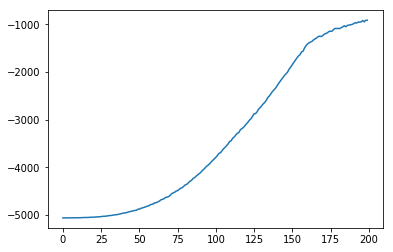

In [11]:
plt.plot(epoch_elbos)

In [12]:
# enc, dec, optimizer = initialize()
# batch_size = BATCH_SIZE
# log_gammas = torch.ones((BATCH_SIZE, K)) * (1 / K)
# Y_1 = Y.float().cuda() 
# optimizer.zero_grad()
# q, qx_mu, qx_sigma = enc(Y_1, batch_size=batch_size, num_samples=NUM_SAMPLES)
# log_gammas = compute_loggammas(alpha_hat, nu_ks, W_ks, m_ks, beta_ks, qx_mu, qx_sigma, batch_size, D, K)
# print(log_gammas)
# p = dec(Y_1, q, num_samples=NUM_SAMPLES)
# loss = - elbo_nn(qx_mu, qx_sigma, log_gammas, alpha_0, nu_0, W_0, m_0, beta_0, alpha_hat, nu_ks, W_ks, m_ks, beta_ks, batch_size, D, K, q, p, sample_dim=None, batch_dim=None, log_weights=None, size_average=True, reduce=True)
# loss.backward()
# optimizer.step()

In [13]:
# ## compute statistics
# N_ks, qx_mu_ks, NS_ks, nk_qx_sigma_ks = stats_2(log_gammas, qx_mu, qx_sigma, D, K)
# ## VBM step -- update global parameters
# alpha_hat, nu_ks, W_ks, m_ks, beta_ks = global_optimal(alpha_0, nu_0, W_0, m_0, beta_0, N_ks, qx_mu_ks, NS_ks, nk_qx_sigma_ks, batch_size, D, K)

In [14]:
Y_1 = Y.float().cuda() 
q, qx_mu, qx_sigma = enc(Y_1, batch_size=batch_size, num_samples=NUM_SAMPLES)
latents = q['z'].dist.mean
obs_recon = dec.dec_hidden(latents)
obs_recon = obs_recon.cpu().squeeze(0).data.numpy()

iteration limit reached


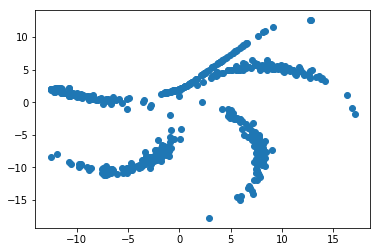

In [15]:
plt.scatter(obs_recon[:, 0], obs_recon[:, 1])

In [16]:
latents_np = latents.cpu().data.squeeze(0).numpy()

In [18]:
cov_ks = torch.zeros((K, D, D))
for k in range(K):
    cov_ks[k] = W_ks[k] / (nu_ks[k] - D - 1)

In [19]:
cov_ks_np = cov_ks.data.numpy()
m_ks_np = m_ks.data.numpy()

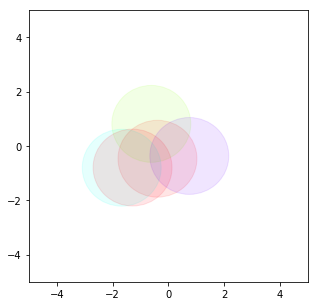

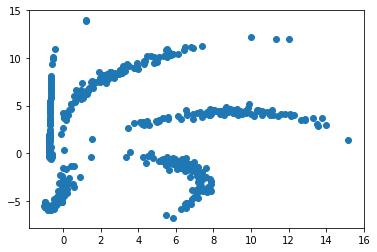

In [23]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
def plot_clusters(mus, covs, K):
    cmap = plt.cm.get_cmap('hsv', K)
    fig, ax = plt.subplots(figsize=(5, 5))
    for i in range(K):
        plot_cov_ellipse(cov=covs[i],
                         pos=mus[i],
                         nstd=1,
                         ax=ax,
                         color=cmap(i),
                         alpha=0.1)
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    plt.show()
plot_clusters(m_ks_np, cov_ks_np, K)
plt.scatter(latents_np[:, 0], latents_np[:, 1])